In [1]:
import comet_ml

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm

import mutils

In [2]:
comet_api = comet_ml.api.API()

In [3]:
exps = comet_api.get("transformer/asha-bayes-bs4")

In [4]:
errors = []
all_dfs = {}
for exp in tqdm(exps):
    meta = exp.get_metadata()
    start_time = dt.datetime.fromtimestamp(meta['startTimeMillis']/1000.0)
    end_time = dt.datetime.fromtimestamp(meta['endTimeMillis']/1000.0)

    try:
        df = mutils.get_exp_csv(exp.id)
    except FileNotFoundError as e:
        errors.append(e)
    df = mutils.get_epoch_info(df)
    df['dt'] = pd.date_range(start_time, end_time, len(df['valid_1mae']))
    all_dfs[exp.id] = df

100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


In [5]:
completed_dfs = {k: df for k, df in all_dfs.items() if len(df) > 4}
dfs = all_dfs

32

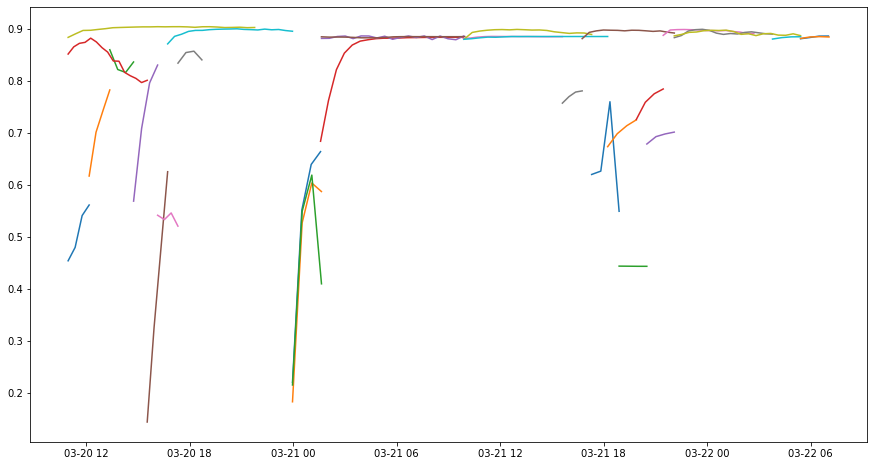

In [20]:
plt.rcParams["figure.figsize"] = (15,8)
for df in dfs.values():
    plt.plot(df['dt'], df['valid_1mae'])
# plt.ylim(0.88, 0.905)
plt.show()

In [23]:
maes = []
dt_stamps = []
dts = []
for k, df in dfs.items():
    i = df['valid_1mae'].argmax()
    maes.append(df['valid_1mae'].iloc[i])
    dt_stamps.append(df['dt'].iloc[i].timestamp())
    dts.append(df['dt'].iloc[i])

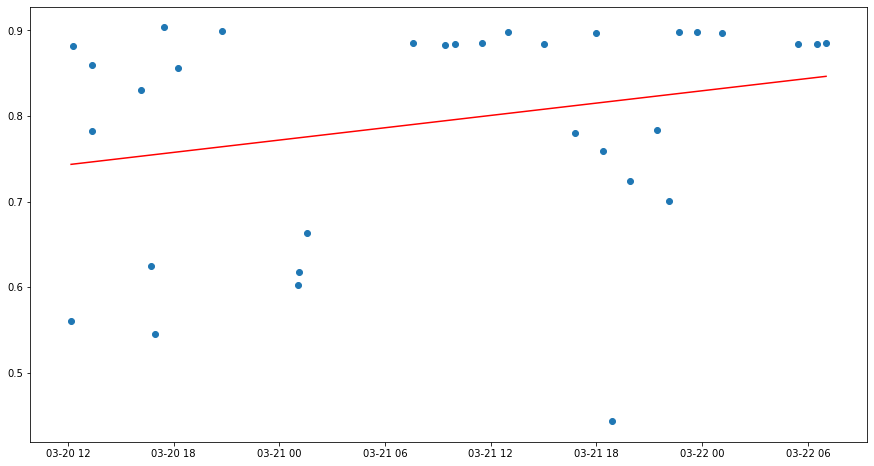

In [64]:
x = dt_stamps
y = maes
df = pd.DataFrame({'x': np.unique(dts), 'y': np.poly1d(np.polyfit(x, y, 1))(np.unique(x))})
plt.plot(df['x'], df['y'], color='r')
df = pd.DataFrame({'dt': dts, 'valid_1mae': maes})
plt.scatter(df['dt'], df['valid_1mae'])
# plt.ylim(0.88, 0.905)
plt.show()

In [50]:
dt_sorted = sorted(list(zip(dts, maes)))
dt_sorted_mae = [mae for _, mae in dt_sorted]
dt_sorted_st = [dt for dt, _ in dt_sorted]

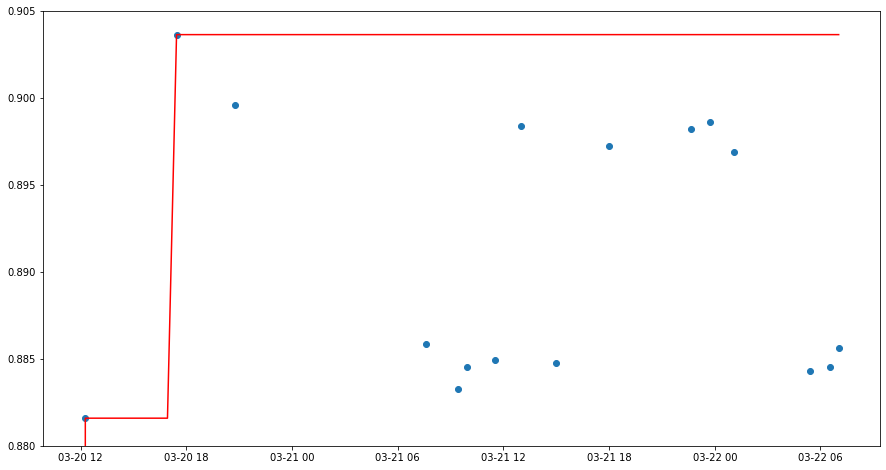

In [61]:
max_acc_mae = np.maximum.accumulate(dt_sorted_mae)
df = pd.DataFrame({'x': dt_sorted_st, 'y': max_acc_mae})
plt.plot(df['x'], df['y'], color='r')
df = pd.DataFrame({'x': dts, 'y': maes})
plt.scatter(df['x'], df['y'])
plt.ylim(0.88, 0.905)
plt.show()

In [66]:
print(f'Number of experiment: {len(dfs)}.')
print(f'Best valid mae: {max_acc_mae[-1]:.4f}.')

Number of experiment: 32.
Best valid mae: 0.9036.


# TODO

how do hyperparameters change?